In [2]:
#mon_env_gdn
import pandas as pd
import os
import re
import nltk
import numpy as np
import time
import matplotlib as plt 
import seaborn as sns
import sklearn
from tqdm.notebook import tqdm as tqdm
from pprint import pprint
import gensim
import spacy
import tweepy as tw
import textblob_fr
import textblob
os.chdir(r"C:\Users\csamassa\Desktop\Mémoire\Nouveau GDN")
#os.chdir(r"C:\Users\Cheik\Desktop\mémoire")
#nltk.download('punkt')

In [94]:
start_time = time.time()

demo=pd.read_csv("DEMOCRATIE_ET_CITOYENNETE.csv", 
                 sep=",",
                 #nrows=10,
                 usecols=[0,10,2,11,13,14,16,17,19,20,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47]
                 ,dtype={"authorZipCode":object}
                 )
fisc=pd.read_csv("LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv", 
                 sep=",",
                 #nrows=10,
                 usecols=[0,10,2,11,12,13,14,15,16,17,18]
                 ,dtype={"authorZipCode":object}
                 )
eco=pd.read_csv("LA_TRANSITION_ECOLOGIQUE.csv", 
                sep=",",
                #nrows=10,               
                usecols=[0,10,2,11,12,14,16,17,18,20,22,23,24,25,26]
                ,dtype={"authorZipCode":object}
                )
                
org=pd.read_csv("ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv", 
                sep=",",
               #nrows=10,
                usecols=[0,10,2,11,13,15,16,19,20,21,24,25,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
                ,dtype={"authorZipCode":object}
               )
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.031277179718018 seconds ---


In [95]:
start_time = time.time()
# On rajoute une colonne comportant le thème de chaque question
demo.insert(column="Thème",value="DEMOCRATIE ET CITOYENNETE",loc=3)
fisc.insert(column="Thème",value="LA FISCALITE ET LES DEPENSES PUBLIQUES",loc=3)
eco.insert(column="Thème",value="LA TRANSITION ECOLOGIQUE",loc=3)
org.insert(column="Thème",value="ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES",loc=3)


# On nettoie le début des questions
def clean_question(df):
    colonnes=df.columns
    colonnes1=[re.sub(pattern=r"\bQ[A-Za-z0-9]+\s+\-\s",repl='',string=nom) for nom in colonnes]
    return(colonnes1)



# On applique tt en même temps
demo.columns,fisc.columns,eco.columns,org.columns=clean_question(demo),clean_question(fisc),clean_question(eco),clean_question(org)
col1=["id", "authorZipCode","Thème"]

def empiller(df):
    stack_0=df.loc[:, ~df.columns.isin(col1)].stack(dropna=False) # prend les QO (toutes les questions sauf celles de col1)
    stack_1=stack_0.reset_index()                                 # On supp l'index pour avoir le level 0 pour la future jointure
    stack_2=stack_1.merge(df[col1],left_on="level_0",right_index=True,how="left")
    stack_2.columns=["idx_0","Question","Réponse","id","authorZipCode","Thème"] #idx_0 c'est le numéro de la ligne dans le fichier original de chaque thème 
    stack_2.dropna(inplace=True)
    return stack_2


demo_1,fisc_1,eco_1,org_1=empiller(demo),empiller(fisc),empiller(eco),empiller(org)

del(demo,fisc,eco,org)# On supp les variables inutiles de l'environnement

contributions=pd.concat([demo_1,fisc_1,eco_1,org_1],axis=0)   #On met tout dans un même df
 
contributions.reset_index(drop=True,inplace=True)

del(demo_1,fisc_1,eco_1,org_1,col1)

contributions.drop(columns="id", inplace=True) # On supp la colonne (on a qu'à utiliser idx_0 si on veut la trace des contributions)


print("--- %s seconds ---" % (time.time() - start_time))

--- 12.565060377120972 seconds ---


In [96]:
contributions

,idx_0,Question,Réponse,authorZipCode,Thème
0,0,title,Les augmentations de rémunérations,79190,DEMOCRATIE ET CITOYENNETE
1,0,En qui faites-vous le plus confiance pour vous...,Le citoyen,79190,DEMOCRATIE ET CITOYENNETE
2,0,Y a-t-il d'autres points sur la démocratie et ...,Afin d’éviter de creuser les inégalités ne plu...,79190,DEMOCRATIE ET CITOYENNETE
3,1,title,rénover l'enquête publique pour en faire un vr...,01800,DEMOCRATIE ET CITOYENNETE
4,1,En qui faites-vous le plus confiance pour vous...,Un instrument de démocratie locale à modernise...,01800,DEMOCRATIE ET CITOYENNETE
...,...,...,...,...,...
5963582,111952,Quand vous pensez à l'évolution des services p...,"Je n'en vois pas beaucoup, mais je constate pa...",50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963583,111952,Quels sont les services publics qui doivent le...,"La SNCF , la renationalisation et en refaire u...",50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963584,111952,"Si oui, comment ?",En les laissant faire preuve de bon sens avec ...,50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES
5963585,111952,"Si oui, comment ?",En simplifiant les normes tout en maintenant u...,50260,ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES


In [6]:
#start_time = time.time()

#contributions=pd.read_csv('contributions.csv',dtype={"authorZipCode":object})

#print("--- %s seconds ---" % (time.time() - start_time))

In [97]:
start_time = time.time()

def compte_group(df,nom,fichier=None,export=False):
    resultat=df.loc[df["Réponse"].str.contains(nom,case=False, regex=True)]
    ###On va mettre chaque thème dans une feuille différente
    ##D'abord on filtre les résultats par thèmes
    resultat["nb_occurr"]=resultat.loc[:,"Réponse"].str.count(pat=nom, flags=re.I)
    if export==True:
        resultat_1=resultat.loc[resultat["Thème"]=="DEMOCRATIE ET CITOYENNETE"]
        resultat_2=resultat.loc[resultat["Thème"]=="LA FISCALITE ET LES DEPENSES PUBLIQUES"]
        resultat_3=resultat.loc[resultat["Thème"]=="LA TRANSITION ECOLOGIQUE"]
        resultat_4=resultat.loc[resultat["Thème"]=="ORGANISATION DE L'ETAT ET DES SERVICES PUBLIQUES"] # je sais que c'est public mais changer ça est trop chiant à faire pzrce que faudra changer le nom des thèmes (ou y'a la faute aussi)
    
        writer = pd.ExcelWriter(fichier+'.xlsx', engine='xlsxwriter')
    
        resultat_1.to_excel(writer, sheet_name="DEMOCRATIE")
        resultat_2.to_excel(writer, sheet_name="FISCALITE")
        resultat_3.to_excel(writer, sheet_name="TRANSITION_ECOLOGIQUE")
        resultat_4.to_excel(writer, sheet_name="ORGANISATION_DE_LETAT") 
    
        writer.save()
    return(resultat)

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0010001659393310547 seconds ---


On va prendre un exemple pour essayer notre code: toutes les contributions du GDN qui contiennent les mots pandémie, épidémie sras, coronavirus

In [98]:
start_time = time.time()
corona=compte_group(contributions,r"\bpand[e-é]mi[a-z]\b|\b[e-é]pid[e-é]mie\b|\bsras\b|\bcoronavirus\b")


print("--- %s seconds ---" % (time.time() - start_time))

#DF series.apply est plus rapide que df.apply

#On ne  prend que les contributions de plus d'une phrase


--- 79.98548364639282 seconds ---


C:\Users\csamassa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [99]:
start_time = time.time()

aleo=corona["Réponse"].apply(nltk.sent_tokenize)
essai=pd.DataFrame(aleo.apply(pd.Series).stack()).reset_index()#la fonction series fait que le séparateur devient la virgule entre chaque éléments de la liste, le stack fait qu'on les empile, on a un multi index où chaque index de level 0= numéro de la contribution, level 1= numéro de la phrase dans la contribution

#On ajoute le nombre de phrases de chaque contributions
essai_gpby=essai.groupby(by="level_0",as_index=False)[0].count()

essai=essai.merge(essai_gpby,on="level_0")


essai.columns=["level_0","nb_sent","sent","nb_sent_total"]
contain=essai.loc[essai["sent"].str.contains(r"\bpand[e-é]mi[a-z]\b|\b[e-é]pid[e-é]mie\b|\bsras\b|\bcoronavirus\b",regex=True,case=False)]

# On met dans un dictionnaire l'index de chaque phrase contenant notre pattern
dico_lvl_contain=dict(zip(contain.index,zip(contain["nb_sent"],contain["nb_sent_total"])))

print("--- %s seconds ---" % (time.time() - start_time))

#DF series.apply est plus rapide que df.apply

#On ne  prend que les contributions de plus d'une phrase

--- 0.43302488327026367 seconds ---


Pour chaque phrase qui contient les mots qu'on veut, on prend celle d'avant et celle d'après. 
Si jamais la phrase qui contient les patterns est la première, python va renvoyer une erreur lorsqu'on va lui demander 
de prendre la phrase d'avant vu qu'il n'y a rien avant, viceversa si c'est après. 
Pour résoudre cela, on va dire à python d'exclure la première lorsqu'on lui demandera de prendre les phrases x-1 et la dernière phrase quand on lui demande de prendre les phrases x+1 (encore une fois si y'a rien après x on va avoir une erreur index out of bounds). 
On a selectionné dans une autre opérationles phrases qui contiennent le pattern, cette opération a pour but de prendre x-1 et x+1 pas x. 
Si la première phrase contient le pattern, python ne va prendre que celle qui la suit, et si dernière phrase contient le pattern, python ne va prendre que celle qui la précède, 
Si la première et la deuxième phrase contiennent le patern, python va prendre celle qui la suit (x+1), et la ligne suivante python va de nouveau prendre la première (x-1, qui contient le pattern),  et la troisème (x+1), la deuxième étant x sur cette ligne (x+1 la ligne précédente)

In [100]:
start_time = time.time()

idx_avant=[[k-1,k,v] for (k,v) in dico_lvl_contain.items() if v[0]>0] #prend la phrase d'avant si la phrase  (celle qui matche le pattern) n'est pas la première de la contribution, donc d'index supérieur à 0
phrase_avant=essai.loc[[x[0] for x in idx_avant],]
phrase_avant["id_x"]=essai.loc[[x[1] for x in idx_avant],].index # On ajoute l'index des phrases qui contiennent la phrase du patern(celle d'après du coup si répond aux conditions du for)
phrase_avant.columns=["level_0","nb_sent_av", "sent_av","nb_sent_total","id_x"]

idx_apres=[[k+1,k,v] for (k,v) in dico_lvl_contain.items() if v[0]<(v[1]-1)] # # prend la phrase d'après si la phrase n'est pas la dernière de la contribution, donc d'index inférieure au nombre de phrases dans la contribution. on ajoute moins 1 parce que v[1] c'est la taille par ex 20 et v[0] c'est l'index (0:19) donc faut mettre v[1]-1 pour que ça corresponde

phrase_apres=essai.loc[[x[0] for x in idx_apres],]
phrase_apres["id_x"]=essai.loc[[x[1] for x in idx_apres],].index #On ajoute l'index des phrases du pattern (celle d'avant du coup si matche les conditions)
phrase_apres.columns=["level_0","nb_sent_ap", "sent_ap","nb_sent_total","id_x"]

contain=contain.rename_axis('id_x').reset_index() #On ajoute la colonne de l'id pour la jointure
essai_final=contain.merge(phrase_avant, on="id_x", how="outer").merge(phrase_apres,on="id_x",how="outer") #On fait une union des trois dataframes
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.031003236770629883 seconds ---


In [101]:
essai_final.loc[:,["sent_av","sent","sent_ap"]]

,sent_av,sent,sent_ap
0,Que tous les profs les informent de l’existenc...,"Lutte contre EPIDEMIE sida, diminution nb d’av...",Tous les enfants ont les mêmes droits.
1,qui est une injustice sociale exorbitante au r...,Prévue pour faire face aux risques d'épidémie ...,Elle donne donc lieu à une immigration sanitai...
2,NaN,Les gens ne partiraient pas si leur vie n'étai...,NaN
3,"Ensuite la langue, les lois, les DEVOIRS.",Si leur dossier est recevable parce que la gue...,Si comme dirait le Premier Ministre Néozélanda...
4,NaN,Il faut pourvoir distinguer les asiles d'urgen...,"Pour les autres, il faut faire appliquer des c..."
...,...,...,...
199,Le rétablissement du jour de carence suffirait...,"le taux d’absentéisme pour raisons de santé, q...",le problème tient au statut très avantageux de...
200,"ça ne se passe pas si aml que ça, sauf que de ...","aussi des congés, une épidémie et des services...",NaN
201,Les cabinets de médecins sont débordés et la p...,Lorsqu’on a besoin d’une consultation simple (...,Il s’agirait d’un niveau « 1 » qui desorgorger...
202,NaN,Les pénuries de médicaments de plus en plus fr...,Il faut assurer notre indépendance dans ce dom...


In [102]:
essai_final['sent_av']=essai_final['sent_av'].astype(str).replace('nan','')
essai_final['sent_ap']=essai_final['sent_ap'].astype(str).replace('nan','')


In [103]:
essai_final["phrase_av_ap"]=essai_final[['sent_av', 'sent','sent_ap']].apply(lambda x: ''.join(x), axis=1)


In [114]:
essai_final["phrase_av_ap"]

0      Que tous les profs les informent de l’existenc...
1      qui est une injustice sociale exorbitante au r...
2      Les gens ne partiraient pas si leur vie n'étai...
3      Ensuite la langue, les lois, les DEVOIRS.Si le...
4      Il faut pourvoir distinguer les asiles d'urgen...
                             ...                        
199    Le rétablissement du jour de carence suffirait...
200    ça ne se passe pas si aml que ça, sauf que de ...
201    Les cabinets de médecins sont débordés et la p...
202    Les pénuries de médicaments de plus en plus fr...
203    Une chaine crypté d'accès à un espace concitoy...
Name: phrase_av_ap, Length: 204, dtype: object

In [27]:
# Stopwords et punct removal perso, mais on va plutôt utiliser celui de Spacy
'''
def stop_words(liste=False):
    stopwords=pd.read_csv("stopwords.csv",sep=';')
    nvx_stpwds=pd.DataFrame(liste,dtype=str)
    stopwords=pd.concat([stopwords["a"],nvx_stpwds[0]],axis=0,ignore_index=True)
    stopwords=pd.concat([stopwords,stopwords.str.upper(),stopwords.str.capitalize()],axis=0, ignore_index=True)
    
    return(stopwords.tolist())
stopwords=stop_words(['oui','non','faut','faudrait','une','qu','il'])


essai_final["text_processed"] = essai_final["phrase_av_ap"].map(lambda x: re.sub('[,\.!?:]', ' ', x))
essai_final["text_processed"]=essai_final["text_processed"].map(lambda x:' '.join([word for word in x.split() if word not in (stopwords)]))#On enlève les stopwords

'''

In [104]:
from spacy import displacy
import fr_core_news_sm
from spacy.lemmatizer import Lemmatizer
from spacy.lang.fr.stop_words import STOP_WORDS
nlp = fr_core_news_sm.load()
#stop_list=["oui","non","faut","faudrait","une","qu","il"]

#nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
    
"""
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    """
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
#nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)


In [121]:
nlp1=fr_core_news_sm.load()

In [122]:
def entitizer (df,colonne):
    dico_ent=[]
    def nlpizer(text):
        pre_nlp= nlp1(text)
        return(pre_nlp)
    
    def entizer(df)
        
    for ent in df[colonne].apply(lambda x: nlpizer(x)):
         dico_ent.append(ent.text, ent.start_char, ent.label_)
            
    return dico_ent

In [123]:
entitizer(essai_final, "phrase_av_ap")

AttributeError: 'tuple' object has no attribute 'text'

In [110]:
for ent in doc.ents:
        entité.append(ent.text, ent.start_char, ent.label_)

AttributeError: 'list' object has no attribute 'ents'

In [106]:
doc_list = []
entité=[]
# Iterates through each article in the corpus.
for doc in tqdm(essai_final["phrase_av_ap"]):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)    
    doc_list.append(pr)
    

In [17]:
ents=[]
for doc in tqdm(essai_final["phrase_av_ap"]):
    
    for ent in doc.ents:
        prc=nlp(ent)
        prc.append(ent.text, ent.start_char, ent.label_)

AttributeError: 'list' object has no attribute 'ents'

In [14]:
doc_list[9]

['culte',
 'pré-carré',
 'n',
 'héler',
 'réserver',
 'élite',
 '.c',
 'pandémie',
 'grave',
 'vaccin',
 'sérum',
 'réseau',
 'sociau',
 'anonymat',
 'détruire',
 'société',
 'exprimer',
 'crainte',
 'représaille',
 'juridique',
 'bon',
 'nombre',
 'faux',
 'idée',
 'nuisible',
 'bêtise',
 'illimiter']

In [24]:
dictionnaire = gensim.corpora.Dictionary(doc_list) # dictionnaire des tokens uniques

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [25]:
corpus = [dictionnaire.doc2bow(doc) for doc in doc_list]

In [26]:
doc_130 = corpus[130]
for i in range(len(doc_130)):
    print("Le mot {} (\"{}\") aparait {} fois.".format(doc_130[i][0], 
                                               dictionnaire[doc_130[i][0]], 
doc_130[i][1]))

Le mot 55 ("faire") aparait 1 fois.
Le mot 72 ("épidémie") aparait 1 fois.
Le mot 110 ("exemple") aparait 1 fois.
Le mot 120 ("vrai") aparait 1 fois.
Le mot 567 ("attendre") aparait 1 fois.
Le mot 577 ("remplacer") aparait 1 fois.
Le mot 1042 ("prendre") aparait 1 fois.
Le mot 1125 ("hiver") aparait 1 fois.
Le mot 1162 ("maladie") aparait 1 fois.
Le mot 1309 ("totalement") aparait 1 fois.
Le mot 1591 ("plante") aparait 1 fois.
Le mot 1659 ("local") aparait 2 fois.
Le mot 1711 ("insecte") aparait 1 fois.
Le mot 1722 ("biodiversité") aparait 1 fois.
Le mot 1728 ("dengue") aparait 1 fois.
Le mot 1870 ("flore") aparait 1 fois.
Le mot 1906 ("Australie") aparait 1 fois.
Le mot 1907 ("bloquer") aparait 1 fois.
Le mot 1908 ("chikungunya?et") aparait 1 fois.
Le mot 1909 ("chose?une") aparait 1 fois.
Le mot 1910 ("exotique") aparait 1 fois.
Le mot 1911 ("grosse") aparait 1 fois.
Le mot 1912 ("importation") aparait 1 fois.
Le mot 1913 ("moustique") aparait 2 fois.
Le mot 1914 ("préserve") aparait

In [12]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [39]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionnaire,
                                           num_topics=3, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.019*"épidémie" + 0.012*"l" + 0.009*"faire" + 0.009*"d" + 0.007*"pouvoir" '
  '+ 0.007*"n" + 0.007*"cas" + 0.007*"devoir" + 0.005*"  " + 0.005*"maladie"'),
 (1,
  '0.011*"  " + 0.011*"épidémie" + 0.007*"gestion" + 0.007*"administratif" + '
  '0.007*"n" + 0.007*"devoir" + 0.007*"faire" + 0.006*"l" + 0.005*"falloir" + '
  '0.005*"pandémie"'),
 (2,
  '0.017*"épidémie" + 0.012*"l" + 0.010*"  " + 0.010*"d" + 0.007*"faire" + '
  '0.005*"n" + 0.005*"santé" + 0.005*"y" + 0.004*"falloir" + '
  '0.004*"politique"')]


In [32]:
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break


[(0, 0.05924481494731159),
 (1, 0.1321443107530509),
 (2, 0.1418129870198082),
 (3, 0.1418129870198082),
 (4, 0.1418129870198082),
 (5, 0.1321443107530509),
 (6, 0.1418129870198082),
 (7, 0.07805288262146544),
 (8, 0.1418129870198082),
 (9, 0.1321443107530509),
 (10, 0.1418129870198082),
 (11, 0.31128290243047163),
 (12, 0.1418129870198082),
 (13, 0.1321443107530509),
 (14, 0.1418129870198082),
 (15, 0.1048898431085945),
 (16, 0.1418129870198082),
 (17, 0.1418129870198082),
 (18, 0.12464470279943649),
 (19, 0.1418129870198082),
 (20, 0.2856635005255116),
 (21, 0.1418129870198082),
 (22, 0.1418129870198082),
 (23, 0.1321443107530509),
 (24, 0.1418129870198082),
 (25, 0.10134879271045097),
 (26, 0.1418129870198082),
 (27, 0.1321443107530509),
 (28, 0.2836259740396164),
 (29, 0.1418129870198082),
 (30, 0.1418129870198082),
 (31, 0.1418129870198082),
 (32, 0.1418129870198082),
 (33, 0.10011945646355355),
 (34, 0.1418129870198082),
 (35, 0.05079841497700909),
 (36, 0.1418129870198082),
 (37

In [33]:
###LDA_multicore
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionnaire, passes=2, workers=2)


In [34]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"épidémie" + 0.012*"l" + 0.009*"pouvoir" + 0.009*"d" + 0.008*"cancer" + 0.008*"devoir" + 0.008*"faire" + 0.007*"	 " + 0.007*"grippe" + 0.007*"mettre"
Topic: 1 
Words: 0.018*"épidémie" + 0.009*"devoir" + 0.009*"  " + 0.006*"limiter" + 0.006*"chasse" + 0.006*"vie" + 0.005*"l" + 0.005*"aide" + 0.005*"n" + 0.005*"faire"
Topic: 2 
Words: 0.021*"épidémie" + 0.010*"l" + 0.009*"pouvoir" + 0.008*"faire" + 0.008*"falloir" + 0.008*"n" + 0.007*"pandémie" + 0.006*"vie" + 0.006*"y" + 0.005*"aller"
Topic: 3 
Words: 0.021*"  " + 0.016*"épidémie" + 0.012*"gestion" + 0.011*"administratif" + 0.009*"l" + 0.009*"santé" + 0.008*"faire" + 0.008*"social" + 0.006*"devoir" + 0.005*"n"
Topic: 4 
Words: 0.032*"d" + 0.019*"l" + 0.016*"épidémie" + 0.009*"n" + 0.007*"devoir" + 0.007*"qu" + 0.006*"faire" + 0.006*"enfant" + 0.006*"  " + 0.005*"médical"
Topic: 5 
Words: 0.014*"épidémie" + 0.008*"population" + 0.008*"n" + 0.008*"antibiotique" + 0.006*"France" + 0.006*"eau" + 0.006*"prendre" + 0.00

In [38]:
#évaluation modèle
for index, score in sorted(lda_model[corpus[50]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.9844813346862793	 
Topic: 0.032*"d" + 0.019*"l" + 0.016*"épidémie" + 0.009*"n" + 0.007*"devoir"


Topic: 0 Word: 0.002*"faire" + 0.002*"vouloir" + 0.002*"impôt" + 0.002*"suicide" + 0.002*"contribuable" + 0.002*"provoquer" + 0.002*"gagne" + 0.002*"quitter" + 0.002*"crédit" + 0.002*"déjection"
Topic: 1 Word: 0.002*"revoir" + 0.002*"allocation" + 0.002*"falloir" + 0.002*"médecin" + 0.002*"   " + 0.002*"jamais" + 0.002*"virus" + 0.002*"	 " + 0.001*"pognon" + 0.001*"dingue"
Topic: 2 Word: 0.004*"cancer" + 0.003*"maladie" + 0.002*"chronique" + 0.002*"espèce" + 0.002*"toucher" + 0.002*"véritable" + 0.002*"chasse" + 0.002*"jeune" + 0.002*"animal" + 0.002*"apparition"
Topic: 3 Word: 0.003*"devoir" + 0.002*"année" + 0.002*"  " + 0.002*"taxer" + 0.002*">" + 0.002*"=" + 0.002*"faire" + 0.002*"peur" + 0.002*"comportement" + 0.002*"source"
Topic: 4 Word: 0.003*"falloir" + 0.002*"pouvoir" + 0.002*"cas" + 0.002*"risque" + 0.002*"entreprise" + 0.002*"médical" + 0.002*"l" + 0.002*"etat" + 0.002*"terme" + 0.002*"atteindre"
Topic: 5 Word: 0.002*"l" + 0.002*"agriculture" + 0.002*"guerre" + 0.002*"nanti

In [4]:
# initialize api instance
auth = tw.OAuthHandler(consumer_key='',
                        consumer_secret='')

auth.set_access_token('',
                        '')
api = tw.API(auth, wait_on_rate_limit=True)


In [5]:
swords=["pandemie","pandémie","epidemie","epidémie","sras","coronavirus"]
OU=" OR "
search_words= OU.join(["#"+x for x in swords])
search_words+=" AND (@gouvernementFR OR @Elysee OR @EmmanuelMacron OR @Matignon)"
search_words+=" -filter:links"
search_words+=" AND -filter:retweets"
search_words+=" AND -filter:replies"
search_date="2020-06-01"

On prend le premier élément de la liste (on va considérer que si le tweet devait être labelisé par un hashtag, ce serait le premier mentionné), et on extrait les tags des dictionnaires avec leur clé

In [6]:
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="fr",
              since=search_date, tweet_mode='extended').items(30)
def tweet_recup(tweets):
    tweet_list=[]
    for tweet in tweets:
        tweet_text=tweet.full_text
        tweed_id_str=tweet.id_str
        location=tweet.user.location
        username = tweet.user.screen_name
        acctdesc = tweet.user.description
        following = tweet.user.friends_count
        followers = tweet.user.followers_count
        totaltweets = tweet.user.statuses_count
        tweetcreatedts = tweet.created_at
        retweetcount = tweet.retweet_count
        hashtags = tweet.entities['hashtags']
        usercreatedts = tweet.user.created_at
        dico={"tweet_text":tweet_text,
                         "tweed_id_str":tweed_id_str,
                         "tweetcreatedts":tweetcreatedts,
                         "location":location,
                         "username":username,
                         "acctdesc":acctdesc,
                         "following":following,
                         "followers":followers,
                         "totaltweets":totaltweets,
                         "usercreatedts":usercreatedts,
                         "retweetcount": retweetcount,
                         "hashtags": hashtags}
        tweet_list.append(dico)
    tweets_df=pd.DataFrame(tweet_list,columns=list(dico.keys()))

    return tweets_df

df=tweet_recup(tweets)
df.to_excel("tweets.xlsx")

In [8]:
print(search_words)

#pandemie OR #pandémie OR #epidemie OR #epidémie OR #sras OR #coronavirus AND (@gouvernementFR OR @Elysee OR @EmmanuelMacron OR @Matignon) -filter:links AND -filter:retweets AND -filter:replies


In [7]:
df["hashtags"].apply(lambda x: x[0]["text"]) # 


0                                               hypoxie
1                                           coronavirus
2     ouvrez_nous_les_frontières_visa_campusFranceAl...
3                                           coronavirus
4                                           coronavirus
5     ouvrez_nous_les_frontières_visa_campusFranceAl...
6                                               COVID19
7                                           coronavirus
8                                               COVID19
9                                           coronavirus
10                                          coronavirus
11                                                 SRAS
12    ouvrez_nous_les_frontières_visa_campusFranceAl...
13                                            COVID__19
14                                        deconfinement
15                                               ALERTE
16                                            COVID__19
17                                             S

In [137]:
###Pour les grosses requêtes
def scraptweets(search_words, date_since, numTweets, numRuns):
    
    # Define a for-loop to generate tweets at regular intervals
    # We cannot make large API call in one go. Hence, let's try T times
    
    # Define a pandas dataframe to store the date:
    db_tweets = pd.DataFrame(columns = ['username', 'tweed_id_str','acctdesc', 'location', 'following',
                                        'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts',
                                        'retweetcount', 'tweet_text', 'hashtags']
                                )
    program_start = time.time()
    for i in range(0, numRuns):
        # We will time how long it takes to scrape tweets for each run:
        start_run = time.time()
        
        # Collect tweets using the Cursor object
        # .Cursor() returns an object that you can iterate or loop over to access the data collected.
        # Each item in the iterator has various attributes that you can access to get information about each tweet
        tweets = tw.Cursor(api.search, q=search_words, lang="fr", since=search_date, tweet_mode='extended').items(numTweets)
# Store these tweets into a python list
        tweet_list = [tweet for tweet in tweets]
# Obtain the following info (methods to call them out):
        # user.screen_name - twitter handle
        # user.description - description of account
        # user.location - where is he tweeting from
        # user.friends_count - no. of other users that user is following (following)
        # user.followers_count - no. of other users who are following this user (followers)
        # user.statuses_count - total tweets by user
        # user.created_at - when the user account was created
        # created_at - when the tweet was created
        # retweet_count - no. of retweets
        # (deprecated) user.favourites_count - probably total no. of tweets that is favourited by user
        # retweeted_status.full_text - full text of the tweet
        # tweet.entities['hashtags'] - hashtags in the tweet
# Begin scraping the tweets individually:
        noTweets = 0
        for tweet in tweet_list:
# Pull the values
            username = tweet.user.screen_name
            tweed_id_str=tweet.id_str
            acctdesc = tweet.user.description
            location = tweet.user.location
            following = tweet.user.friends_count
            followers = tweet.user.followers_count
            totaltweets = tweet.user.statuses_count
            usercreatedts = tweet.user.created_at
            tweetcreatedts = tweet.created_at
            retweetcount = tweet.retweet_count
            hashtags = tweet.entities['hashtags']
            try:
                tweet_text = tweet.retweeted_status.full_text
            except AttributeError:  # Not a Retweet
                tweet_text = tweet.full_text
# Add the 11 variables to the empty list - ith_tweet:
            ith_tweet = [username, tweed_id_str, acctdesc, location, following, followers, totaltweets,
                         usercreatedts, tweetcreatedts, retweetcount, tweet_text, hashtags]
# Append to dataframe - db_tweets
            db_tweets.loc[len(db_tweets)] = ith_tweet
# increase counter - noTweets  
            noTweets += 1
        
        # Run ended:
            end_run = time.time()
            duration_run = round((end_run-start_run)/60, 2)
        
            print('no. of tweets scraped for run {} is {}'.format(i + 1, noTweets))
            print('time take for {} run to complete is {} mins'.format(i+1, duration_run))
        
            time.sleep(900) #15 minute sleep time
        
        
        """
  from datetime import datetime
    
    # Obtain timestamp in a readable format
    export_timestamp = datetime.today().strftime('%Y%m%d_%H%M%S')
# Define working path and filename
    path = os.getcwd()
    filename = path+"tweets"+export_timestamp+".xlsx"
# Store dataframe in csv with creation date timestamp
    db_tweets.excel(filename, index = False)
    
    program_end = time.time()
    print('Scraping has completed!')
    print('Total time taken to scrap is {} minutes.'.format(round(program_end - program_start)/60, 2))
"""
    db_tweets["hashtags"]=db_tweets["hashtags"].apply(lambda x: x[0]["text"]) # On prend le premier élément de la liste (qui est le seul élement finalement), et on extrait les tags des dictionnaires avec leur cl
    return(db_tweets)

 

In [ ]:
scraptweets(search_words=search_words, date_since="2020-07-01", numTweets=20, numRuns=10)

In [ ]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 

class PreProcessTweets:
    def clean_tweet(self):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", self).split())
    
    def stopwords(self):
        self._stopwords = nlp(self)
   """     
    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet["text"]),tweet["label"]))
        return processedTweets
    """
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
        tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return [word for word in tweet if word not in self._stopwords]

On supprime les caractères spéciaux de nos tweets pour permettre au modèle d'analyse de sentiment qu'on va utiliser de reconnaitre le texte. Spécificité française: on va garder les voyelles avec des trémas, des circonflexes et des accents. Il ne s'agit pas de caractères spéciaux en français. 

On  fait également le choix de ne pas supprimer les hashtags mentionnés dans les tweets. Il semble qu'ils aient un sens et une valeur significatifs pour l'analyse de sentiments. 
(le 23/07): Certains tweets ont des tonalités contradictoires, peut-être est-ce les hashtags qui faussent les résultats

On va donc essayer de les supprimer pour voir s'il y a du mieux

In [227]:
###Grosse fonction pour occurrence à retravailler

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
class ProcessTweets:
    def clean_tweet(self):
        '''
        Fonction de nettoyage de tweets, supprimant les liens, les caractères spéciaux en utilisant des regex et supprimant les stopwords, 
        la ponctuation, et tokenizant  en utilisant nlp() de spacy (auquel on ajouté la suppression des stopwords)
        '''
        pre=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z(àâäéèêëùûüïîôö) \t])|(\w+:\/\/\S+)", " ", self).split())
        return pre.lower
    def df_clean(df):
        text=pd.DataFrame(df["tweet_text"].apply(lambda x: PreProcessTweets.clean_tweet(x)))
        return(text)
    
    def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
       # analysis=text.apply(lambda tweet: TextBlob(tweet).sentiment)
        polarité=TextBlob(tweet,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer())
            
        if polarité.sentiment.polarity > 0:
            return 'positive'
        elif polarité.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
        

In [60]:
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

def test (df): ### le 23/07
    
    def clean_tweet(string):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        pre=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z(àâäéèêëùûüïîôö) \t])|(\w+:\/\/\S+)", " ", string).split())
        
        return pre.lower()
        
    def sentiment_analyzer (text):
        c=TextBlob(text,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer())
        return c.sentiment[0]
   
    def df_clean_sentiment(df1):
        df["clean_text"]=df["tweet_text"].apply(lambda x: clean_tweet(x))
        df["sentiment"]=df["clean_text"].apply(lambda x: sentiment_analyzer(x))
        
        df.loc[a["sentiment"]>0,"label"]="positif" # On met cette information dans une autre colonne et pas en remplaçant la valeur numérique pour pouvoir nuancer la positivité ou négativité après
        df.loc[a["sentiment"]==0,"label"]="neutre"
        df.loc[a["sentiment"]<0,"label"]="négatif"
        df["hashtags"]=df["hashtags"].apply(lambda x: x[0]["text"]) # On prend le premier élément de la liste (qui est le seul élement finalement), et on extrait les tags des dictionnaires avec leur cl

        #df["label_sentiment"]=df["label_sentiment"]
        return(df)
    
    return(df_clean_sentiment(df)) # On appelle notre fonction
    

In [57]:
test(df).to_excel(r"C:\Users\csamassa\OneDrive - OCCURRENCE\Memoire-master\test_24_07.xlsx")


Constat assez mitigé pour notre modèle d'analyse de sentiments. Les tweets désignéss par Textblob comme étant négatifs, semblent correctes (autrement dit je les aurais aussi catégorisés comme négatifs). Pour les tweets positifs en revanche, je ne suis pas tout à fait convaincu. A vrai dire j'ai beaucoup de mal à les faire rentrer dans une catégorie par conséquent j'en aurais mis une bonne partie dans les neutres. Toutefois, il n'est pas scandaleux de voir qu'ils ont une polarité supérieure à 0 (peuvent être interprétés comme ayant un sentiment positif) d'autant que la polarité des tweets positifs les plus "discutables" est très proche de 0.
Je pense donc que plutôt que regarder les labels (positfs, négatifs ou neutres) il fauat regarder la polarité. Du coup ce que je vais sûrement faire c'est ajouter des catégories intermédiaires par exemple (peu positif, très positif assez positif) etc... Pour nuancer les sentiment et analyser plus précisément. 

Vérifier aussi si dans mon expression régulière les caractères que je décide de garder ne biaisent pas peu le sentiment idem pour les hastags que j'ai décidé de garder
En outre, il serait intéressant de voir si je fais les mêmes constats sur un corpus de tweets plus important en utilisant la grosse fonction plus haut. A voir....
Désormais je vais faire quelques statistiques

In [61]:
df_juillet=test(df)
df_juillet

,tweet_text,tweed_id_str,tweetcreatedts,location,username,acctdesc,following,followers,totaltweets,usercreatedts,retweetcount,hashtags,clean_text,sentiment,label
0,J'ai été victime d'#hypoxie le 22 Juillet 2020...,1286414066932748289,2020-07-23 21:33:08,,Rhollingue,,0,81,11856,2012-03-05 23:33:43,0,hypoxie,j ai été victime d hypoxie le 22 juillet 2020 ...,0.400000,positif
1,Nouvelle sortie prévue demain @Matignon @Jea...,1286389414856450048,2020-07-23 19:55:11,France,azizzemouri1,journaliste @LePoint,870,3764,5429,2017-12-31 23:54:41,0,coronavirus,nouvelle sortie prévue demain cette fois à roi...,0.100000,positif
2,Ne gâchez pas nos rêves et laissez nous bâtir ...,1286259726477664256,2020-07-23 11:19:50,Alger,khamari_chaouki,Architect at EPAU\nain naâdja\n22 YO\nfrom gue...,123,25,339,2014-08-28 10:42:39,1,ouvrez_nous_les_frontières_visa_campusFranceAl...,ne gâchez pas nos rêves et laissez nous bâtir ...,0.000000,neutre
3,Aucun pays au monde ne distribue de masques gr...,1286063455653502978,2020-07-22 22:19:56,,kinsuo,#sport #motivation #soutienfdo\nIci on parle R...,1111,661,2628,2009-06-18 12:26:22,0,coronavirus,aucun pays au monde ne distribue de masques gr...,-0.026667,négatif
4,Nous sommes prêt à faire des tests de #coronav...,1286061974061711365,2020-07-22 22:14:03,Algérie,yasou_yas09,Alge-Reine ❣️♓️,2,7,71,2020-07-20 22:29:58,6,coronavirus,nous sommes prêt à faire des tests de coronavi...,0.140000,positif
5,Pourquoi nous laisser continuer nos démarches ...,1285928115022290944,2020-07-22 13:22:08,Algérie,yasou_yas09,Alge-Reine ❣️♓️,2,7,71,2020-07-20 22:29:58,19,ouvrez_nous_les_frontières_visa_campusFranceAl...,pourquoi nous laisser continuer nos démarches ...,-0.062500,négatif
6,Ras le bol des propos alarmistes des diverses ...,1285874420054142978,2020-07-22 09:48:46,"Paris, France",Running93137953,,2,6,299,2019-12-23 19:03:21,0,COVID19,ras le bol des propos alarmistes des diverses ...,0.084000,positif
7,Hier les dirigeants européens ont conclu un ac...,1285842709593427970,2020-07-22 07:42:46,Paris,FOCadres,Union syndicale confédérale des #cadres et #in...,717,2283,10622,2014-02-05 16:25:45,1,coronavirus,hier les dirigeants européens ont conclu un ac...,-0.016667,négatif
8,#COVID19 #coronavirus #confinement #desobeissa...,1285681693047885826,2020-07-21 21:02:57,,Price35025409,,70,6,1308,2020-06-04 21:30:22,0,COVID19,covid19 coronavirus confinement desobeissance ...,0.100000,positif
9,#coronavirus @EmmanuelMacron @EPhilippe_LH @J...,1285561630097645574,2020-07-21 13:05:51,,costes_raphael,si ma tante en avait deux ça serait mon oncle,29,9,2,2020-07-21 12:41:14,0,coronavirus,coronavirus lh reouvrez les boites de nuit par...,0.000000,neutre


In [74]:
%matplotlib inline
sns.set(style="whitegrid")

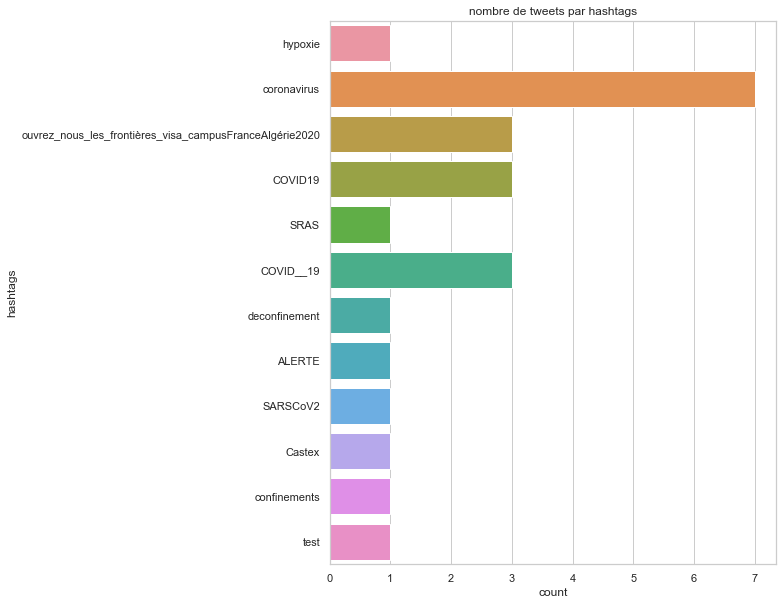

In [82]:
plt.pyplot.figure(figsize=(8,10))
ax=sns.countplot(y="hashtags",data=df_juillet).set_title("Nombre de tweets par hashtags")

In [93]:
### Pourcentage de tweets par sentiments
pcent_pos=(len(df_juillet.loc[df_juillet["label"]=="positif"])/len(df_juillet))*100

pcent_neg=(len(df_juillet.loc[df_juillet["label"]=="négatif"])/len(df_juillet))*100

pcent_neut=(len(df_juillet.loc[df_juillet["label"]=="neutre"])/len(df_juillet))*100

dico_sentiment={"positif": (len(df_juillet.loc[df_juillet["label"]=="positif"])/len(df_juillet))*100,
                "negatif": (len(df_juillet.loc[df_juillet["label"]=="négatif"])/len(df_juillet))*100,
                "neutre":  (len(df_juillet.loc[df_juillet["label"]=="neutre"])/len(df_juillet))*100}

for k,v in dico_sentiment.items():
    print('Le sentiment associé aux tweets est à {} % {}'.format(v,k))

Le sentiment associé aux tweets est à 58.333333333333336 % positif
Le sentiment associé aux tweets est à 25.0 % negatif
Le sentiment associé aux tweets est à 16.666666666666664 % neutre


Text(0.5, 1.0, 'Hashtags par polarité moyenne')

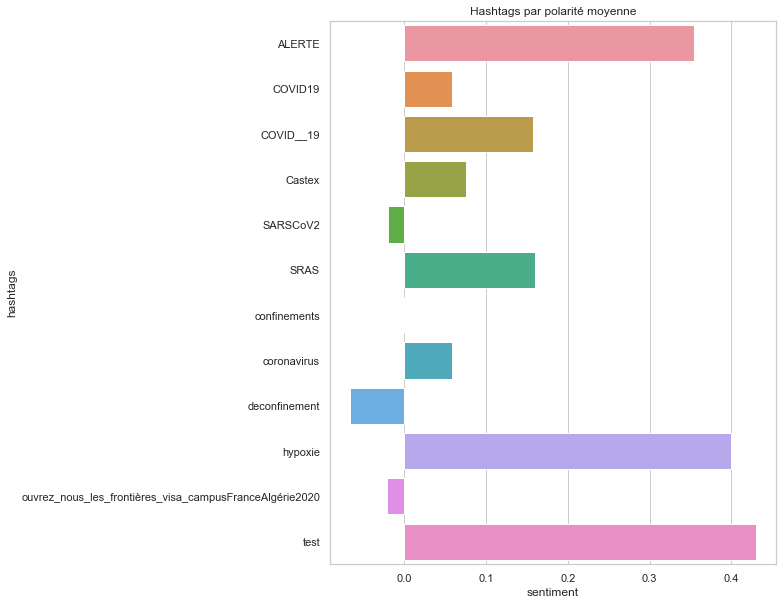

In [83]:
### Hashtags par polarité moyenne
sent_hashtag=df_juillet.groupby(by="hashtags",as_index=False).mean().loc[:,["hashtags","sentiment"]]

plt.pyplot.figure(figsize=(8,10))
sns.barplot(y=sent_hashtag["hashtags"],x=sent_hashtag["sentiment"], orient="h").set_title("Hashtags par polarité moyenne")
